<a href="https://colab.research.google.com/github/HuyKhoi-code/fruits/blob/master/20_edge%2Bcluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
import cv2
import glob
from google.colab.patches import cv2_imshow
import numpy as np
from numpy import array 
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
def clustering_image(img):
  #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  vectorized = img.reshape((-1,3))
  vectorized = np.float32(vectorized)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  attempts=10
  ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
  center = np.uint8(center)
  res = center[label.flatten()]
  result_image = res.reshape((img.shape))
  return result_image, center

In [5]:
def remove_light_color(img, center_color):
  light_color = max(sum(center_color[0]), sum(center_color[1]))
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      if sum(img[x][y]) == light_color:
        img[x][y][0]=0
        img[x][y][1]=0
        img[x][y][2]=0
  return img

0


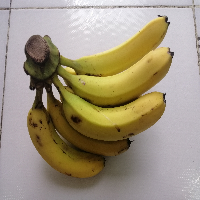

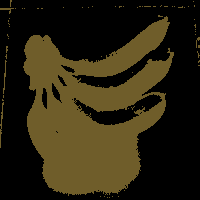

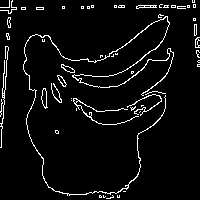

1


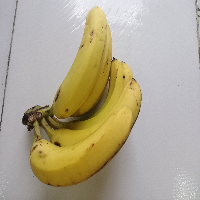

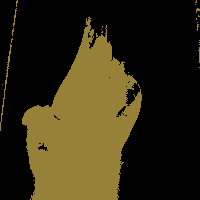

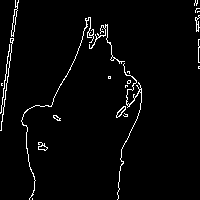

2


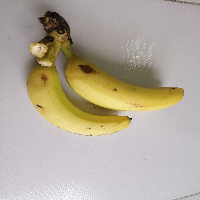

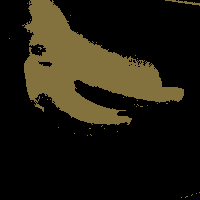

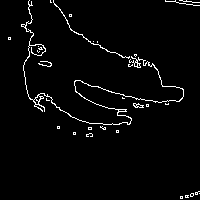

3


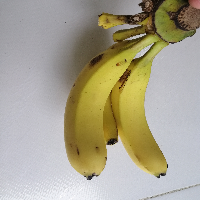

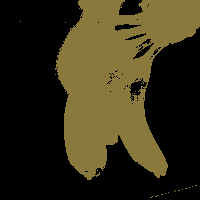

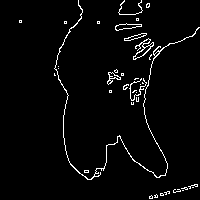

4


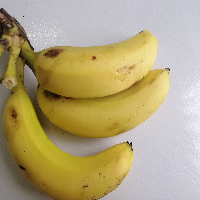

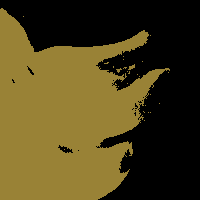

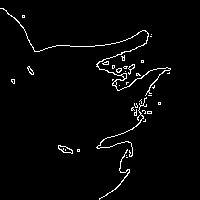

5


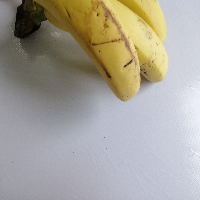

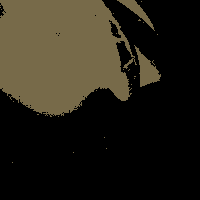

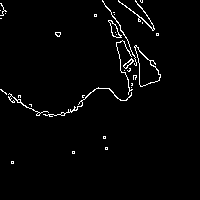

6


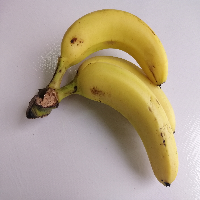

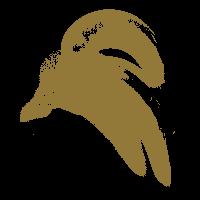

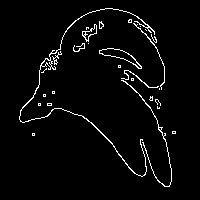

7


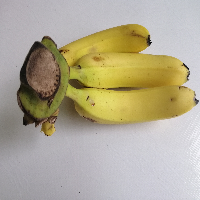

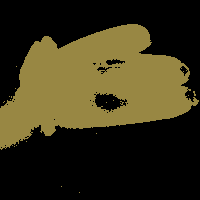

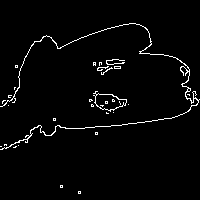

8


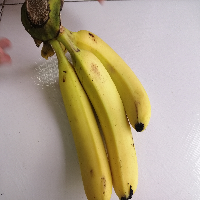

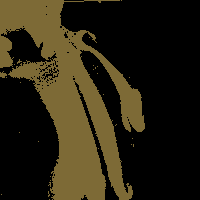

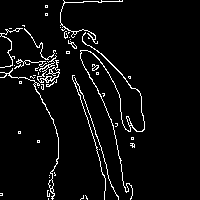

9


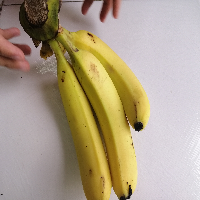

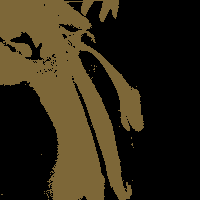

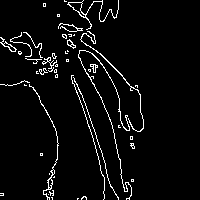

In [6]:
def Canny_Detect(img):
    #resized = cv2.resize(img, (200, 200))
    #gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur (img, (3, 3), 0)
    #cv2_imshow(blur)
    edge = cv2.Canny (blur, 70, 50)
    return edge
for id in range (10):
    img = cv2.imread ("/content/drive/My Drive/Fruit recognition/data/chuoi/chuoi_"+str(id)+".jpg")
    print (id)
    resized = cv2.resize(img, (200, 200))
    image, center = clustering_image(resized )
    image = remove_light_color(image, center)
    cv2_imshow(resized)
    edge = Canny_Detect(image)
    cv2_imshow(image)
    cv2_imshow(edge)

done 250 image


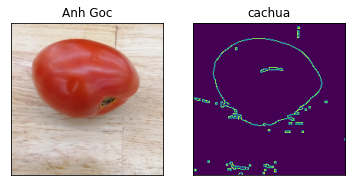

done 250 image


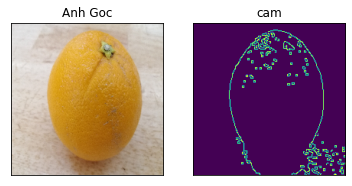

done 250 image


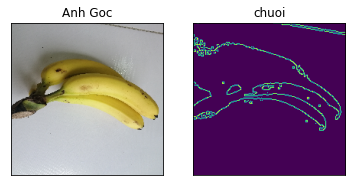

done 250 image


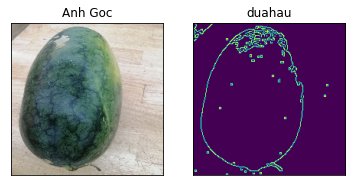

done 250 image


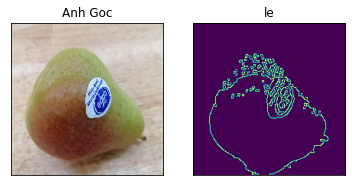

done 250 image


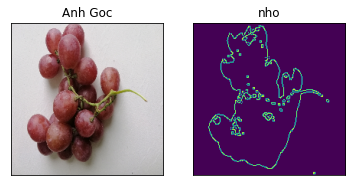

done 250 image


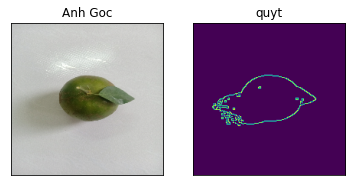

done 250 image


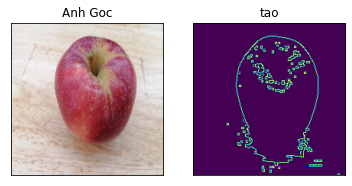

done 250 image


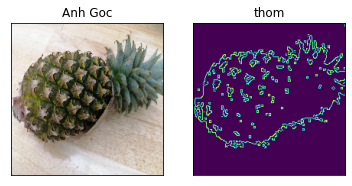

done 250 image


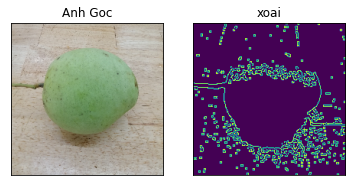

In [7]:
path = '/content/drive/My Drive/Fruit recognition/data'
name_fruits = ['cachua', 'cam', 'chuoi', 'duahau', 'le', 'nho', 'quyt', 'tao', 'thom', 'xoai']
dataset_train = {}
dataset_test = {}
test_size = 0.2
number = 1
dim = (200, 200)

for name in name_fruits:
  index = 0
  images_train = []
  images_test = []
  while index < 250:
    img_path = path+'/'+name+'/'+name+'_'+str(index)+'.jpg'
    
    #print(img_path)
    fruit_img = cv2.imread(img_path)
    fruit_img = cv2.resize(fruit_img, dim)
    fruit_img = cv2.cvtColor(fruit_img,cv2.COLOR_BGR2RGB)
    cluster, center = clustering_image(fruit_img )
    image = remove_light_color(cluster, center)
    edge = Canny_Detect(image)

    if len(images_test) < test_size*(len(os.listdir(path+'/'+name))):
      images_test.append(edge)
    else:
      images_train.append(edge)
    #cv2_imshow(rb_img)
    if index == 249:
      print('done {} image'.format(index + 1))
      figure_size = 6
      plt.figure(figsize=(figure_size,figure_size))
      plt.subplot(1,2,1),plt.imshow(fruit_img)
      plt.title('Anh Goc'), plt.xticks([]), plt.yticks([])
      plt.subplot(1,2,2),plt.imshow(edge)
      plt.title(name), plt.xticks([]), plt.yticks([])
    
      plt.show()
    index+=1
  dataset_train[name] = images_train
  dataset_test[name] = images_test

In [8]:
def features_grid(img):
    features = np.array([], dtype='uint8')
    section = 1
    
    for y in range(0, img.shape[0], 40):
        for x in range(0, img.shape[1], 40):
            
            # Cropping the image into a section.
            section_img = img[y:y+40, x:x+40]
            
            # Claculating the mean and stdev of the sectioned image.
            section_mean = np.mean(section_img)
            section_std = np.std(section_img)
            
            # Appending the above calculated values into features array.
            features = np.append(features, [section_mean, section_std])
    
    # Returning the features array.
    return features

In [9]:
all_imgs = np.zeros((1, 50), dtype='uint8')

progress_counter = 0
name = []
section_mean = []
section_std = []
for fruits in dataset_train: 
    for img in dataset_train[fruits]:


        img_features = features_grid(img)
        img_features = img_features.reshape(1, img_features.shape[0])

        all_imgs = np.append(all_imgs, img_features, axis=0)
        progress_counter += 1
        name.append (fruits)

all_imgs = all_imgs[1:]

In [10]:
feature_name = []
section = 1
for y in range(0, 200, 40):
    for x in range(0, 200, 40):
        feature_name.append(f"sec{section}_mean")
        feature_name.append(f"sec{section}_std")
        section += 1

In [11]:
ftb_train = pd.DataFrame(all_imgs, columns= feature_name)
print (ftb_train.shape)
name_col = name
ftb_train.insert(loc = 0, column = "name", value= name_col)
ftb_train.head(200)

(2000, 50)


,name,sec1_mean,sec1_std,sec2_mean,sec2_std,sec3_mean,sec3_std,sec4_mean,sec4_std,sec5_mean,sec5_std,sec6_mean,sec6_std,sec7_mean,sec7_std,sec8_mean,sec8_std,sec9_mean,sec9_std,sec10_mean,sec10_std,sec11_mean,sec11_std,sec12_mean,sec12_std,sec13_mean,sec13_std,sec14_mean,sec14_std,sec15_mean,sec15_std,sec16_mean,sec16_std,sec17_mean,sec17_std,sec18_mean,sec18_std,sec19_mean,sec19_std,sec20_mean,sec20_std,sec21_mean,sec21_std,sec22_mean,sec22_std,sec23_mean,sec23_std,sec24_mean,sec24_std,sec25_mean,sec25_std
0,cachua,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,7.968750,44.368122,8.765625,46.458564,0.478125,11.031467,0.000000,0.000000,0.000000,0.000000,6.375000,39.811862,4.781250,34.588414,6.853125,41.238108,0.000000,0.000000,0.000000,0.000000,6.375000,39.811862,0.000000,0.000000,6.375000,39.811862,0.000000,0.000000,0.000000,0.000000,6.853125,41.238108,7.650000,43.499741,5.737500,37.817239,0.796875,14.232643
1,cachua,0.000000,0.000000,0.478125,11.031467,18.80625,66.647721,2.550000,25.372180,0.0,0.0,0.000000,0.000000,6.375000,39.811862,33.150000,85.757376,22.631250,72.517551,0.000000,0.000000,0.000000,0.000000,6.375000,39.811862,10.040625,49.593802,8.925000,46.863839,0.000000,0.000000,0.000000,0.000000,2.868750,26.894266,15.300000,60.559145,16.256250,62.298299,0.478125,11.031467,0.000000,0.000000,0.796875,14.232643,8.287500,45.217583,0.000000,0.000000,0.000000,0.000000
2,cachua,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.781250,34.588414,6.534375,40.293518,3.506250,29.695117,0.000000,0.000000,3.506250,29.695117,3.984375,31.624996,1.275000,17.986088,8.925000,46.863839,0.000000,0.000000,7.171875,42.159131,5.737500,37.817239,0.000000,0.000000,10.837500,51.440364,0.000000,0.000000,5.418750,36.775242,32.193750,84.693381,21.356250,70.638193,4.143750,32.241054,0.000000,0.000000
3,cachua,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,3.984375,31.624996,6.534375,40.293518,6.534375,40.293518,0.000000,0.000000,1.275000,17.986088,12.271875,54.577735,9.721875,48.831990,7.650000,43.499741,0.000000,0.000000,2.231250,23.748479,5.896875,38.326622,8.925000,46.863839,6.853125,41.238108,0.000000,0.000000,4.143750,32.241054,0.000000,0.000000,2.390625,24.574261,0.000000,0.000000,0.000000,0.000000
4,cachua,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.275000,17.986088,0.0,0.0,0.000000,0.000000,2.868750,26.894266,6.534375,40.293518,2.390625,24.574261,0.000000,0.000000,2.550000,25.372180,6.215625,39.323662,0.000000,0.000000,8.287500,45.217583,0.000000,0.000000,8.287500,45.217583,5.578125,37.300220,0.000000,0.000000,8.765625,46.458564,0.000000,0.000000,6.375000,39.811862,6.853125,41.238108,12.909375,55.903834,1.115625,16.829728,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,cachua,1.593750,20.096423,0.796875,14.232643,1.91250,22.000678,0.000000,0.000000,0.0,0.0,0.000000,0.000000,9.562500,48.445806,6.534375,40.293518,5.737500,37.817239,0.000000,0.000000,6.853125,41.238108,0.159375,6.373008,1.275000,17.986088,6.693750,40.768860,0.000000,0.000000,0.796875,14.232643,8.446875,45.635550,7.650000,43.499741,9.084375,47.265101,0.000000,0.000000,1.593750,20.096423,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
196,cachua,7.968750,44.368122,5.418750,36.775242,13.06875,56.229343,16.734375,63.144488,0.0,0.0,44.465625,96.755065,10.359375,50.342070,0.000000,0.000000,10.040625,49.593802,2.709375,26.144787,12.431250,54.912956,0.000000,0.000000,3.665625,30.352884,11.634375,53.210966,14.821875,59.664815,32.831250,85.405373,10.996875,51.800308,8.446875,45.635550,12.431250,54.912956,0.637500,12.734053,29.484375,81.542549,1.753125,21.070677,1.912500,22.000678,0.000000,0.000000,0.000000,0.000000
197,cachua,0.0

In [12]:
ftb_train.to_csv("/content/drive/My Drive/Fruit recognition/output_input/20_edge+cluster_train_features.csv", index = False)

In [13]:
all_imgs = np.zeros((1, 50), dtype='uint8')

progress_counter = 0
name_test = []
section_mean = []
section_std = []
for fruits in dataset_test: 
    for img in dataset_test[fruits]:


        img_features = features_grid(img)
        img_features = img_features.reshape(1, img_features.shape[0])

        all_imgs = np.append(all_imgs, img_features, axis=0)
        progress_counter += 1
        name_test.append (fruits)

all_imgs = all_imgs[1:]

In [14]:
ftb_test = pd.DataFrame(all_imgs, columns= feature_name)
print (ftb_test.shape)
name_col = name_test
ftb_test.insert(loc = 0, column = "name", value= name_col)
ftb_test.head(200)

(500, 50)


,name,sec1_mean,sec1_std,sec2_mean,sec2_std,sec3_mean,sec3_std,sec4_mean,sec4_std,sec5_mean,sec5_std,sec6_mean,sec6_std,sec7_mean,sec7_std,sec8_mean,sec8_std,sec9_mean,sec9_std,sec10_mean,sec10_std,sec11_mean,sec11_std,sec12_mean,sec12_std,sec13_mean,sec13_std,sec14_mean,sec14_std,sec15_mean,sec15_std,sec16_mean,sec16_std,sec17_mean,sec17_std,sec18_mean,sec18_std,sec19_mean,sec19_std,sec20_mean,sec20_std,sec21_mean,sec21_std,sec22_mean,sec22_std,sec23_mean,sec23_std,sec24_mean,sec24_std,sec25_mean,sec25_std
0,cachua,0.000000,0.000000,0.000000,0.000000,7.650000,43.499741,1.275000,17.986088,0.000000,0.000000,2.709375,26.144787,11.475000,52.862552,14.821875,59.664815,6.056250,38.828670,0.000000,0.000000,15.300000,60.559145,6.056250,38.828670,10.678125,51.077388,3.346875,29.021570,6.056250,38.828670,14.025000,58.134967,6.534375,40.293518,0.000000,0.000000,8.128125,44.795150,3.665625,30.352884,0.637500,12.734053,10.040625,49.593802,16.893750,63.423241,7.650000,43.499741,0.000000,0.000000
1,cachua,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.231250,23.748479,3.346875,29.021570,0.000000,0.000000,8.446875,45.635550,16.256250,62.298299,10.359375,50.342070,0.000000,0.000000,4.621875,34.017883,2.071875,22.891821,1.275000,17.986088,6.375000,39.811862,0.000000,0.000000,0.000000,0.000000,21.515625,70.877093,0.159375,6.373008,15.140625,60.262931,0.000000,0.000000,3.028125,27.622497,6.693750,40.768860,7.012500,41.701467,0.000000,0.000000,0.000000,0.000000
2,cachua,0.000000,0.000000,0.000000,0.000000,5.259375,36.241959,0.000000,0.000000,0.000000,0.000000,3.984375,31.624996,17.212500,63.975912,9.881250,49.214628,8.287500,45.217583,1.275000,17.986088,7.331250,42.611284,0.000000,0.000000,1.275000,17.986088,0.000000,0.000000,6.693750,40.768860,11.315625,52.511342,0.796875,14.232643,0.000000,0.000000,9.881250,49.214628,1.434375,19.071135,0.000000,0.000000,8.606250,46.049172,14.981250,59.964831,12.112500,54.239975,1.275000,17.986088
3,cachua,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.578125,37.300220,9.084375,47.265101,7.331250,42.611284,0.000000,0.000000,0.000000,0.000000,6.375000,39.811862,1.275000,17.986088,7.809375,43.936366,0.000000,0.000000,1.275000,17.986088,4.940625,35.148963,5.418750,36.775242,33.628125,86.280479,1.275000,17.986088,25.659375,76.712040,0.796875,14.232643,6.375000,39.811862,24.543750,75.208115,30.759375,83.051198
4,cachua,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.665625,30.352884,17.212500,63.975912,10.200000,49.969591,0.000000,0.000000,0.000000,0.000000,6.375000,39.811862,0.000000,0.000000,6.375000,39.811862,0.000000,0.000000,0.000000,0.000000,15.618750,61.146021,5.737500,37.817239,7.012500,41.701467,0.000000,0.000000,0.000000,0.000000,1.593750,20.096423,5.259375,36.241959,1.593750,20.096423,0.796875,14.232643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,duahau,1.275000,17.986088,32.193750,84.693381,38.409375,91.209158,52.753125,103.291600,16.575000,62.864094,13.387500,56.873433,9.562500,48.445806,1.275000,17.986088,1.275000,17.986088,13.706250,57.508543,9.243750,47.662452,1.275000,17.986088,0.000000,0.000000,0.000000,0.000000,6.534375,40.293518,8.446875,45.635550,1.434375,19.071135,0.000000,0.000000,4.621875,34.017883,5.896875,38.326622,0.000000,0.000000,25.500000,76.500000,14.025000,58.134967,18.487500,66.125070,0.000000,0.000000
196,duahau,4.303125,32.844786,12.590625,55.245683,33.468750,86.106759,20.240625,68.932405,0.478125,11.031467,3.506250,29.695117,6.375000,39.811862,5.737500,37.817239,5.259375,36.241959,1.912500,22.000678,0.000000,0.000000,6.375000,39.811862,2.550000,25.372180,1.275000,17.986088,7.171875,42.159131,0.000000,0.000000,6.375000,39.811862,0.000000,0.000000,0.000000,0.000000,6.375000,39.811862,0.0

In [15]:
ftb_test.to_csv("/content/drive/My Drive/Fruit recognition/output_input/20_edge+cluster_valid_features.csv", index = False)